# Prepate notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd


from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import log_loss, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from plotting_utilities import *

# Load example data

In [4]:
data = pd.read_csv('data.csv', index_col = 0)

In [5]:
data.head()

,Title,Author,My Rating,Number of Pages,Year Published,Original Publication Year,Date Added,recommended,isbn,categories,description,publisher
0,"Gay New York: Gender, Urban Culture, and the M...",George Chauncey,4,496.0,1995.0,1994.0,2019-11-01,False,NaN,['History'],Shattering the myth that gay life only existed...,Basic Books
1,"The Source of Self-Regard: Selected Essays, Sp...",Toni Morrison,2,354.0,2019.0,2019.0,2019-06-15,False,9.780526e+12,['Literary Collections'],Arguably the most celebrated and revered write...,Knopf
4,Over the Top: A Raw Journey to Self-Love,Jonathan Van Ness,2,400.0,2019.0,2019.0,2019-10-26,False,9.780063e+12,['Biography & Autobiography'],A laugh-and-cry-out-loud memoir from the belov...,Harper
5,Never Enough: The Neuroscience and Experience ...,Judith Grisel,4,256.0,2019.0,2019.0,2019-10-25,False,9.780386e+12,['Biography & Autobiography'],From a renowned behavioral neuroscientist and ...,Doubleday Books
7,Hurricanes: A Memoir,Rick Ross,2,288.0,2019.0,2019.0,2019-10-24,False,9.781488e+12,['Biography & Autobiography'],*NEW YORK TIMES BESTSELLER* “A gripping journe...,Hanover Square Press


In [6]:
labels = pd.read_csv('labels.csv', index_col = 0)

In [7]:
labels = labels.reindex(labels.sum().sort_values(ascending = False).index.tolist(), axis=1)

In [8]:
labels.head()

,natural_sciences,history,culture,social_studies,biography_memoir,medicine,philosophy,literature_fiction,technology
0,False,True,False,True,False,False,False,False,False
1,False,False,True,True,False,False,False,False,False
4,False,False,False,True,True,False,False,False,False
5,True,False,False,False,False,True,False,False,False
7,False,False,True,False,True,False,False,False,False


In [9]:
labels.sum()

natural_sciences      305
history               223
culture               169
social_studies        163
biography_memoir      153
medicine              146
philosophy            128
literature_fiction     77
technology             23
dtype: int64

In [10]:
data = data.join(labels)

# Display of categorical variables, split by secondary field

In [11]:
most_frequent_publishers = data['publisher'].value_counts().sort_values(ascending = False)[:10].index

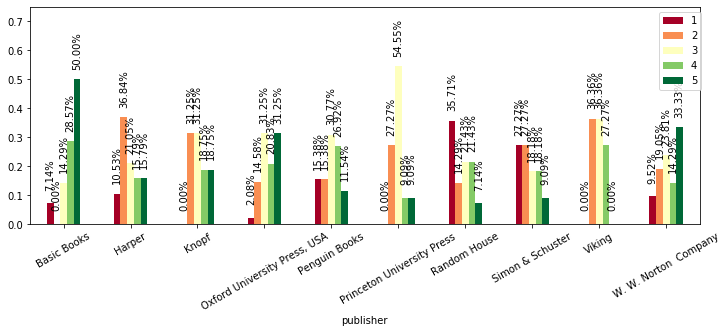

In [12]:
    fig, ax = plt.subplots(1,1, figsize = (12,4))
    data.groupby('publisher')['My Rating'].value_counts(normalize = True).loc[most_frequent_publishers]\
        .unstack().sort_index(axis =1)\
        .plot.bar(ax = ax, cmap = 'RdYlGn')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
    #ax.set_yscale('log')
    for p in ax.patches:
        ax.text(x =  p.get_x() + p.get_width() / 2, 
                y =  p.get_height()+0.1,#max(1e-4, p.get_y() + p.get_height()*1.75),
                s = '%.2f%%'%(p.get_height()*100.),
                va='center', ha='center', rotation = 90)
    ax.set_ylim(0, 0.75)
    ax.legend(bbox_to_anchor=(1.01, 1))
    fig.show()

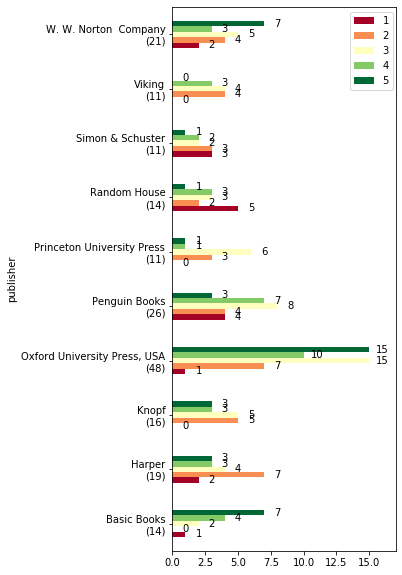

In [13]:
    fig, ax = plt.subplots(1,1, figsize = (4,10))
    df = data.groupby('publisher')['My Rating'].value_counts().loc[most_frequent_publishers]\
        .unstack().sort_index(axis =1)
    totals = df.sum(axis = 1)
    df.plot.barh(ax = ax, cmap = 'RdYlGn')
    ax.set_yticklabels([t.get_text()+'\n(%d)'%totals[t.get_text()] for t in ax.get_yticklabels()])
    #ax.set_xscale('log')
    for p in ax.patches:
        ax.text(x =  p.get_width()+1, 
                y =  p.get_y()+p.get_height()/2,
                s = '%d'%(p.get_width()),
                va='center', ha='center')
    ax.set_xlim(0, 17)
    ax.legend(bbox_to_anchor=(1.01, 1))
    fig.show()

# Display distributions of continuous variable, split by secondary field

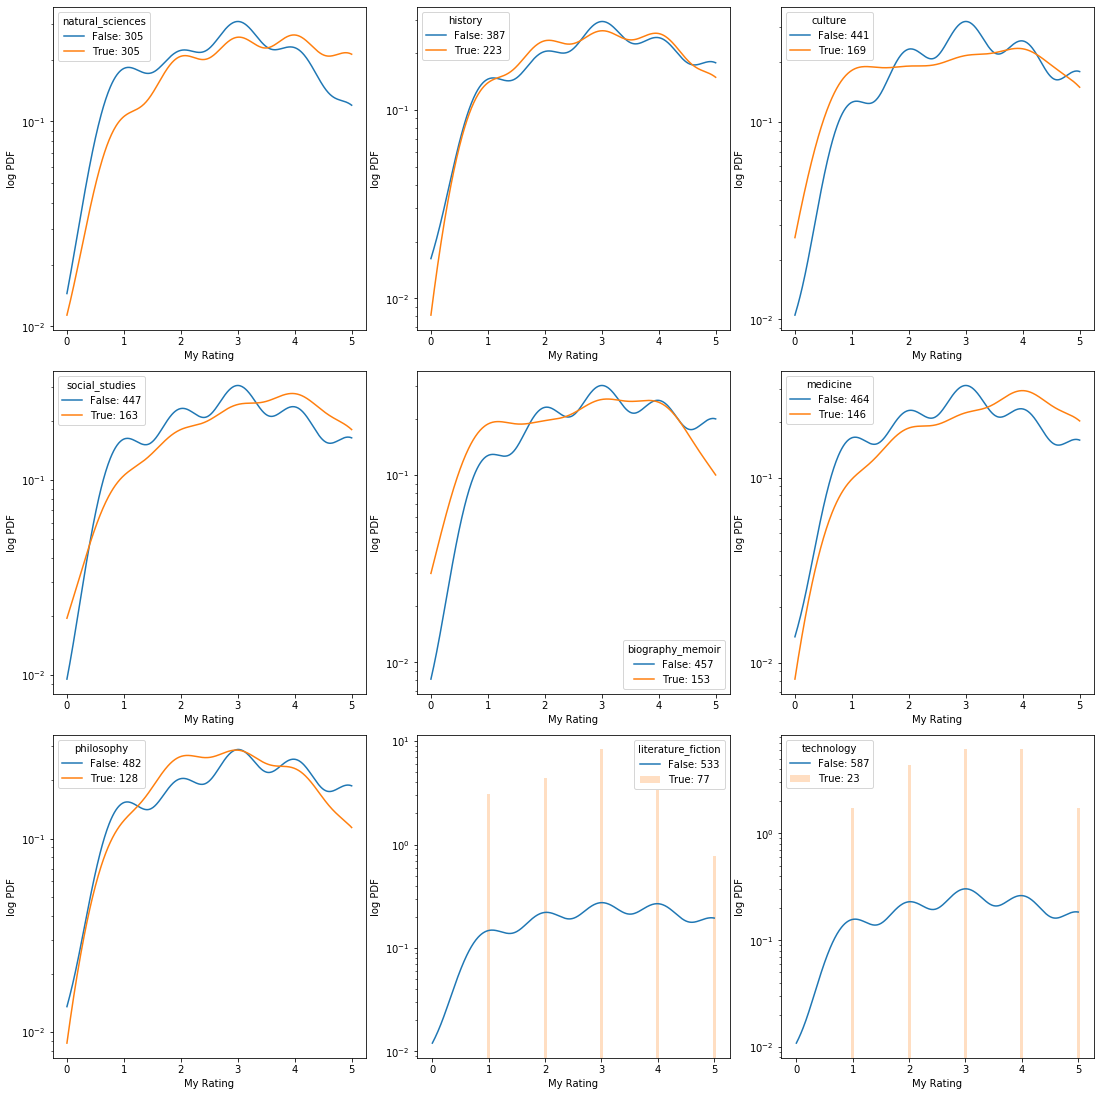

In [14]:
features = labels.columns.tolist()
value_col = 'My Rating'

fig, ax = feature_distributions(data, features, value_col)

# Display distributions of continuous variable, split by secondary field  with highlighted categorizations

In [15]:
data['primary_label'] = labels.idxmax(axis=1)
data['general_category'] = data['literature_fiction'].apply(lambda v: 'fiction' if v else 'nonfiction')

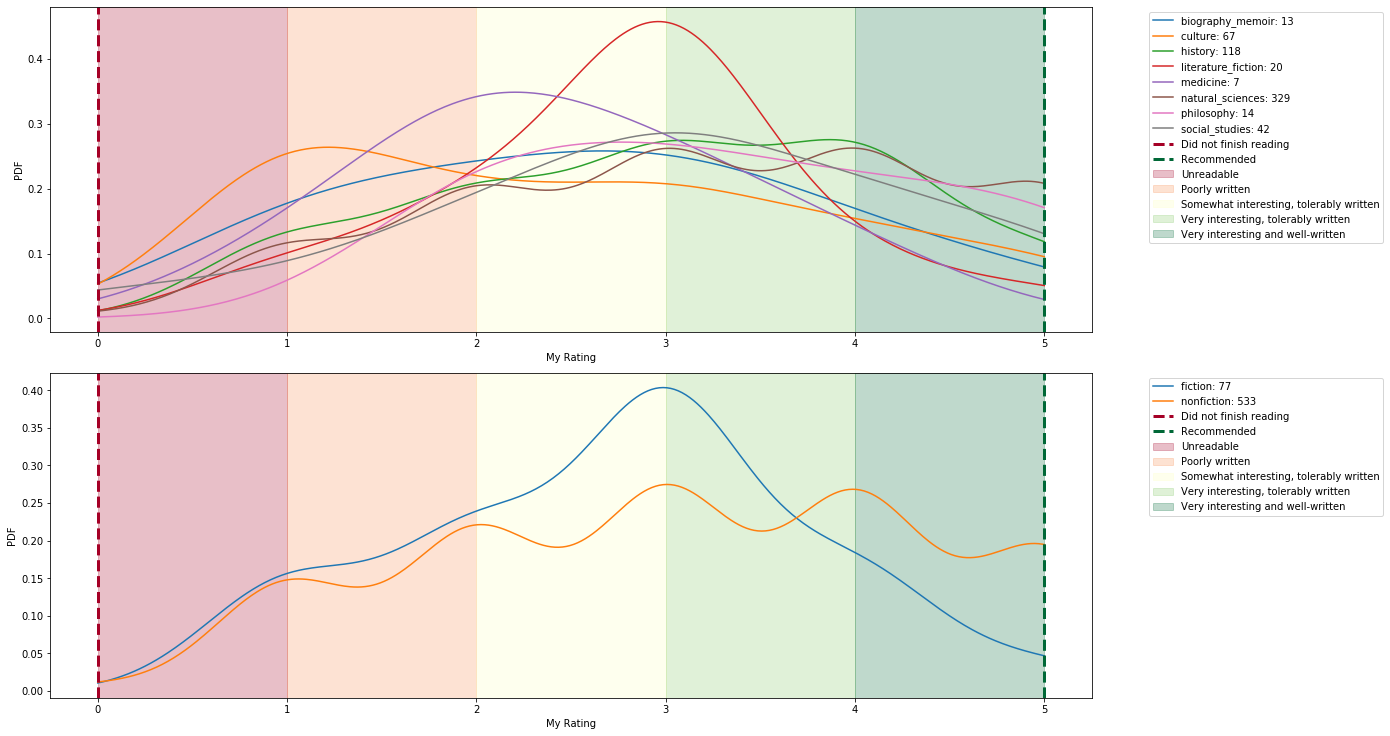

In [16]:
features = ['primary_label', 'general_category']
value_col = 'My Rating'
cmap = matplotlib.cm.get_cmap('RdYlGn')
colors = [cmap(i) for i in np.linspace(0, 1, 5)]

highlighting = [(0, 1, colors[0], 'Unreadable'),
                (1, 2, colors[1], 'Poorly written'),
                (2, 3, colors[2], 'Somewhat interesting, tolerably written'),
                (3, 4, colors[3], 'Very interesting, tolerably written'),
                (4, 5, colors[4], 'Very interesting and well-written')]

edge_values = [(0, colors[0], 'Did not finish reading'),
               (5, colors[4], 'Recommended')]

fig, ax = feature_distributions(data, features, value_col, 
                                ncols = 1, w_scale = 15,
                                min_group_size = 5, log_y = False,
                                highlighting = highlighting, edge_values = edge_values, 
                                anchor_legend = (1.05, 1))

# Display joint plot of continuous variable distributions

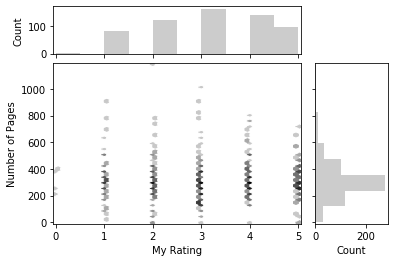

In [17]:
fig, ax_joint, ax_marg_x, ax_marg_y = jointplot(data['My Rating'], data['Number of Pages'])

# Display joint plot of continuous variable distributions, with range highlighting

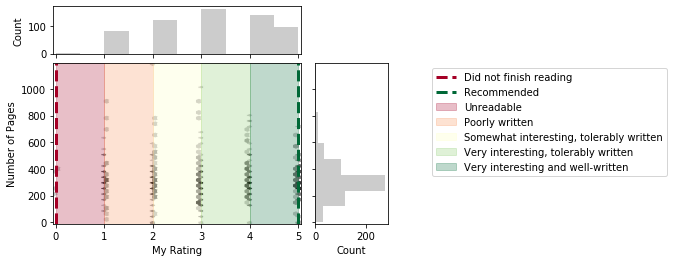

In [18]:
highlighting = [(0, 1, colors[0], 'Unreadable'),
                (1, 2, colors[1], 'Poorly written'),
                (2, 3, colors[2], 'Somewhat interesting, tolerably written'),
                (3, 4, colors[3], 'Very interesting, tolerably written'),
                (4, 5, colors[4], 'Very interesting and well-written')]

edge_values = [(0, colors[0], 'Did not finish reading'),
               (5, colors[4], 'Recommended')]

fig, ax_joint, ax_marg_x, ax_marg_y = jointplot(data['My Rating'], data['Number of Pages'],
                                                highlighting = highlighting, edge_values = edge_values, 
                                                anchor_legend = (2.5, 1) 
                                                )

# Display joint plot of continuous variable distributions, split by category

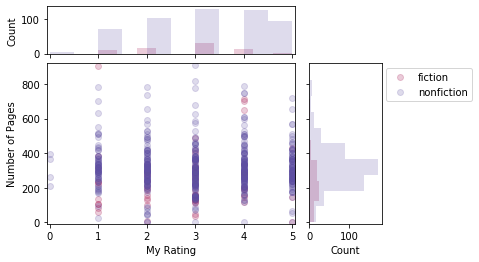

In [19]:
grouped_data = data.groupby('general_category')

cmap = matplotlib.cm.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, len(grouped_data))]


fig = None

ic = 0
for name, group in grouped_data:
    if fig is None:
        fig, ax_joint, ax_marg_x, ax_marg_y = jointplot(group['My Rating'], group['Number of Pages'],
                                                        joint_type = 'scatter', scatter_label = name, 
                                                        c = colors[ic])
        ic += 1
    else:
        jointplot(group['My Rating'], group['Number of Pages'], joint_type = 'scatter', scatter_label = name, 
                  fig_axes = (fig, ax_joint, ax_marg_x, ax_marg_y), c = colors[ic],
                  anchor_legend = (1.35, 1))
        ic += 1

# Comparing ML multi-class classifiers

In [20]:
features = labels.columns.tolist()
label = 'My Rating'

# Stratify balanced data set by rating
f_train, f_test_dev, r_train, r_test_dev = train_test_split(data[features], 
                                                    data[label], 
                                                    test_size=0.40, 
                                                    stratify= data[label], 
                                                    random_state = 73344)

f_dev, f_test, r_dev, r_test = train_test_split(f_test_dev, r_test_dev, 
                                                    test_size=0.50, 
                                                    stratify= r_test_dev, 
                                                    random_state = 73344)


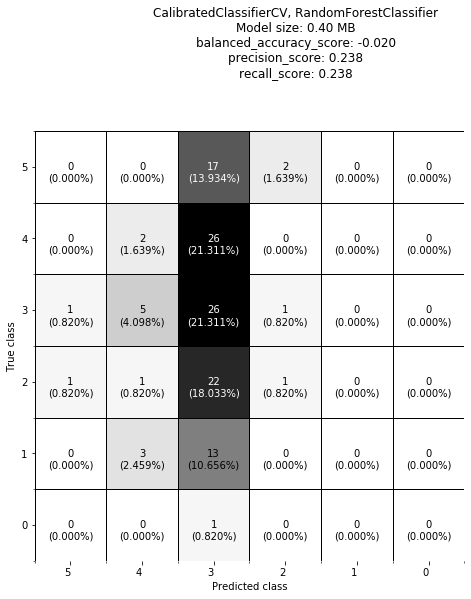

In [21]:
estimators = [RandomForestClassifier(), 
              #ExtraTreesClassifier(),
              #AdaBoostClassifier(), 
              #GradientBoostingClassifier()
             ]

metrics_args = [(balanced_accuracy_score, {'adjusted': True}),
                (precision_score, {'average': 'micro'}),
                (recall_score, {'average': 'micro'})]

for estimator in estimators:
    mr_dev_type, mr_dev_probs, fig, ax = plot_classifier_performance(estimator, metrics_args, 
                                                                     f_train, r_train, f_dev, r_dev)



# Comparing ML binary classifiers

In [22]:
features = labels.columns.tolist()

# Balance data set between fiction and non-fiction general categories
c = 'general_category'
c1 = 'fiction'
c2 = 'nonfiction'


c2_c1_ratio = 4.0
features_balanced = data.loc[(data[c] == c1), features]
N = len(features_balanced)
features_balanced = features_balanced.append(data.loc[(data[c] != c1), features]\
                                                 .sample(n=int(np.ceil(N*c2_c1_ratio)), 
                                                         random_state = 133030))
response_balanced = data.loc[features_balanced.index, c]


# Stratify balanced data set by rating
f_train, f_test_dev, r_train, r_test_dev = train_test_split(features_balanced, 
                                                    response_balanced, 
                                                    test_size=0.40, 
                                                    stratify= response_balanced, 
                                                    random_state = 73344)

f_dev, f_test, r_dev, r_test = train_test_split(f_test_dev, r_test_dev, 
                                                    test_size=0.50, 
                                                    stratify= r_test_dev, 
                                                    random_state = 73344)

print('Training set length: {}\nTraining set distribution:\n{}\n\n'.format(len(r_train),
                                                                       (r_train.value_counts()/len(r_train)*100) ))
print('Development set length: {}\nDevelopment set distribution:\n{}\n\n'.format(len(r_dev),
                                                                       (r_dev.value_counts()/len(r_dev)*100) ))
print('Testing set length: {}\nTesting set distribution:\n{}\n\n'.format(len(r_test),
                                                                       (r_test.value_counts()/len(r_test)*100) ))



Training set length: 231
Training set distribution:
nonfiction    80.08658
fiction       19.91342
Name: general_category, dtype: float64


Development set length: 77
Development set distribution:
nonfiction    79.220779
fiction       20.779221
Name: general_category, dtype: float64


Testing set length: 77
Testing set distribution:
nonfiction    80.519481
fiction       19.480519
Name: general_category, dtype: float64




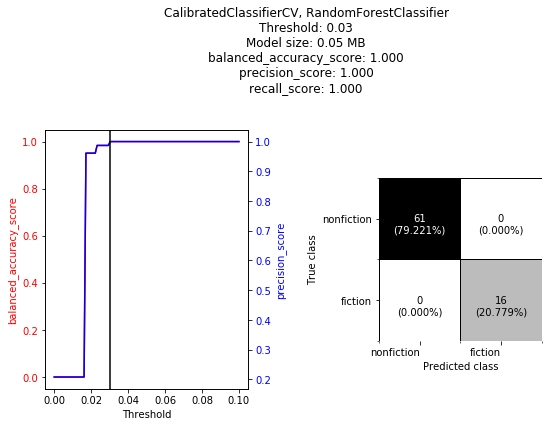

In [23]:
estimators = [RandomForestClassifier(), 
              #ExtraTreesClassifier(),
              #AdaBoostClassifier(), 
              #GradientBoostingClassifier()
             ]

metrics_args = [(balanced_accuracy_score , {'adjusted': True}),
                (precision_score, {'average': 'micro'}),
                (recall_score, {'average': 'micro'})]

for estimator in estimators:
    mr_dev_type, mr_dev_probs, fig, ax = plot_classifier_performance(estimator, metrics_args, 
                                                                     f_train, r_train, f_dev, r_dev, 
                                                                     thresholds = np.linspace(0, 0.1,100))



# Optimizing model hyperparameters

In [24]:
features = labels.columns.tolist()
label = 'My Rating'

# Stratify balanced data set by rating
f_train, f_test_dev, r_train, r_test_dev = train_test_split(data[features], 
                                                    data[label], 
                                                    test_size=0.40, 
                                                    stratify= data[label], 
                                                    random_state = 73344)

f_dev, f_test, r_dev, r_test = train_test_split(f_test_dev, r_test_dev, 
                                                    test_size=0.50, 
                                                    stratify= r_test_dev, 
                                                    random_state = 73344)
nf = len(features)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.6s finished
/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.23301117832037768
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.8s finished
/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                            

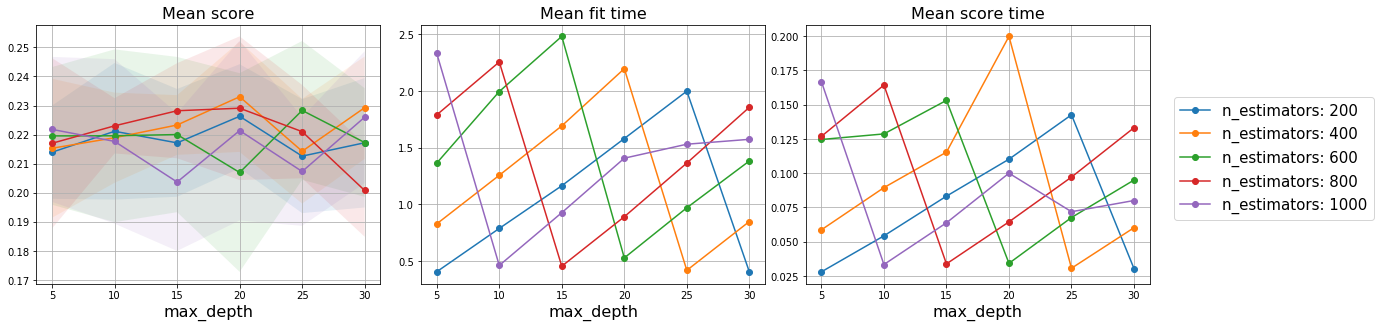

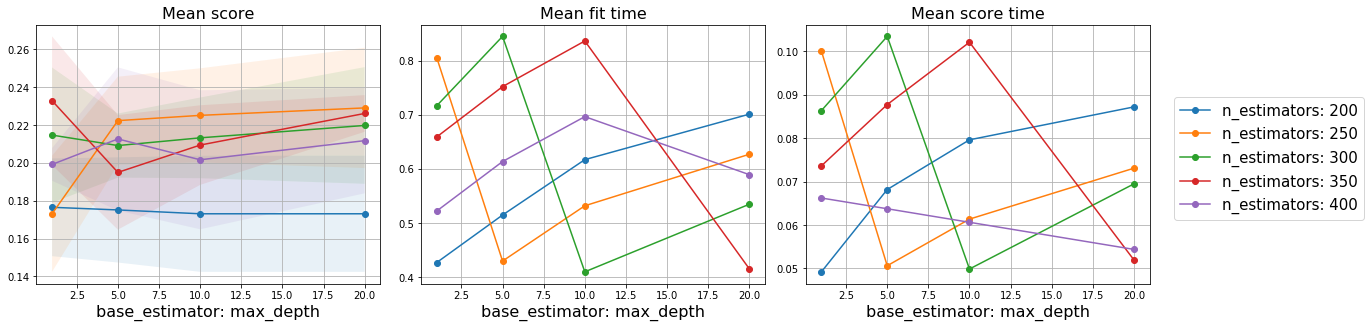

In [25]:
estimators_parameters = [(RandomForestClassifier(), {'n_estimators': [200, 400,  600, 800, 1000],
                                                      'max_features':[nf],
                                                      'min_samples_split': [2],
                                                      'max_leaf_nodes': [None], 
                                                      'max_depth': [5, 10, 15, 20, 25, 30],
                                                      'min_samples_leaf': [1]}, None),
                         (AdaBoostClassifier(), {'base_estimator': [DecisionTreeClassifier(max_depth=1), 
                                                     DecisionTreeClassifier(max_depth=5), 
                                                     DecisionTreeClassifier(max_depth=10), 
                                                     DecisionTreeClassifier(max_depth=20)],
                                                  'n_estimators':[200, 250, 300, 350, 400]}, 'max_depth')
                        ]


for estimator, param_grid, base_estimator_p in estimators_parameters:
    model_gs = GridSearchCV(estimator,
                      param_grid=param_grid,
                      scoring='balanced_accuracy', return_train_score=True,
                      cv=3, n_jobs = -1, verbose = 1)
    model_gs.fit(f_train, r_train)
    results = model_gs.cv_results_
    
    lengths = {key:len(value) for key,value in param_grid.items()}
    p1 = max(lengths.items(), key=operator.itemgetter(1))[0]
    del lengths[p1]
    p2 = max(lengths.items(), key=operator.itemgetter(1))[0]
    
    if base_estimator_p is not None:
        p1_data = np.sort(list(set([classifier.get_params()[base_estimator_p]
                                    for classifier in results['param_base_estimator'].data])))
        if p1 == 'base_estimator':
            p1 += ': '+ base_estimator_p
        else:
            p2 = p1
            p1 = 'base_estimator: '+ base_estimator_p
    else:
        p1_data = np.sort(list(set(results['param_'+p1].data)))
    
    p2_data  = np.sort(list(set(results['param_'+p2].data)))

    plot_grid_search(results,p1_data, p2_data, p1, p2)
        
   
    print(model_gs.best_estimator_)
    print(model_gs.best_score_)

# Event plot of occurances from different categories

In [26]:
data['Date Added'] = pd.to_datetime(data['Date Added'])

In [27]:
time_origin = data['Date Added'].min()
time_period = data['Date Added'].max() - time_origin
time_period = time_period + time_period*0.01


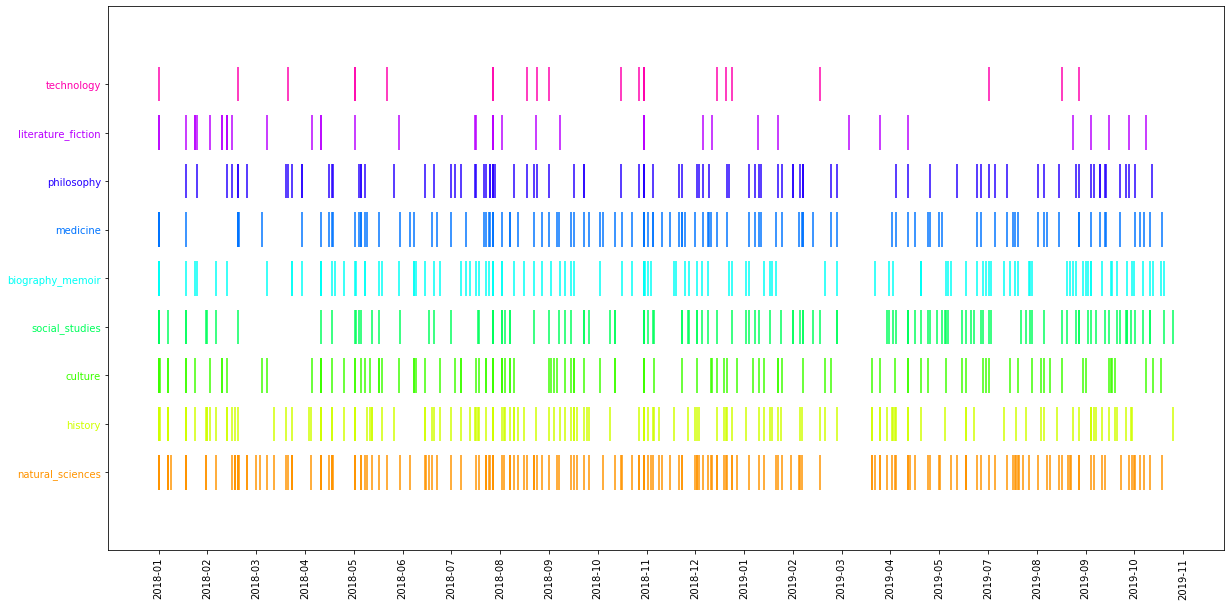

In [28]:
nrows = 1
ncols =1 
fig, ax = plt.subplots(nrows = nrows,ncols = ncols, figsize = (20*ncols,10*nrows))
ax = [ax]
iax = 0

n_months = np.ceil((data['Date Added'].max() - data['Date Added'].min())/np.timedelta64(1, 'M'))
x_ticks = np.linspace(0,1, n_months)

e = labels.set_index((data['Date Added']-time_origin)/time_period)
n_categories = len(e.columns)
offsets = np.linspace(0,1,n_categories)
lengths = 1.0/n_categories - (1.0/n_categories)/5
colors = plt.cm.hsv(np.linspace(0.1,0.9,n_categories))

for r, c in enumerate(e.columns):
    occurance_offsets = e.loc[e[c] == 1].index
    ax[iax].eventplot(list(e.loc[e[c] == 1].index), label = c, 
                      color = colors[r], linelengths = lengths, lineoffsets = offsets[r])
ax[iax].set_ylim([-0.2,1.2])
ax[iax].set_yticks(offsets)
ax[iax].set_yticklabels(e.columns)
for ic in range(len(e.columns)):
    ax[iax].get_yticklabels()[ic].set_color(colors[ic])

x_ticks_labels = [(xt*time_period + time_origin).date().strftime(format = '%Y-%m') for xt in x_ticks]
ax[iax].set_xticks(x_ticks)
ax[iax].set_xticklabels(x_ticks_labels, rotation = 90);


# Event plot of occurances from different categories, highlighting date ranges

In [29]:
saturdays = [ d for d in pd.date_range(data['Date Added'].min(), data['Date Added'].max())
             if d.weekday_name == 'Saturday']
sundays = [d+pd.Timedelta('1 days') for d in saturdays]
weekends = pd.DataFrame(zip(saturdays, sundays), columns = ['start', 'end'])

In [30]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = [d for d in cal.holidays(start=data['Date Added'].min(), end= data['Date Added'].max())]


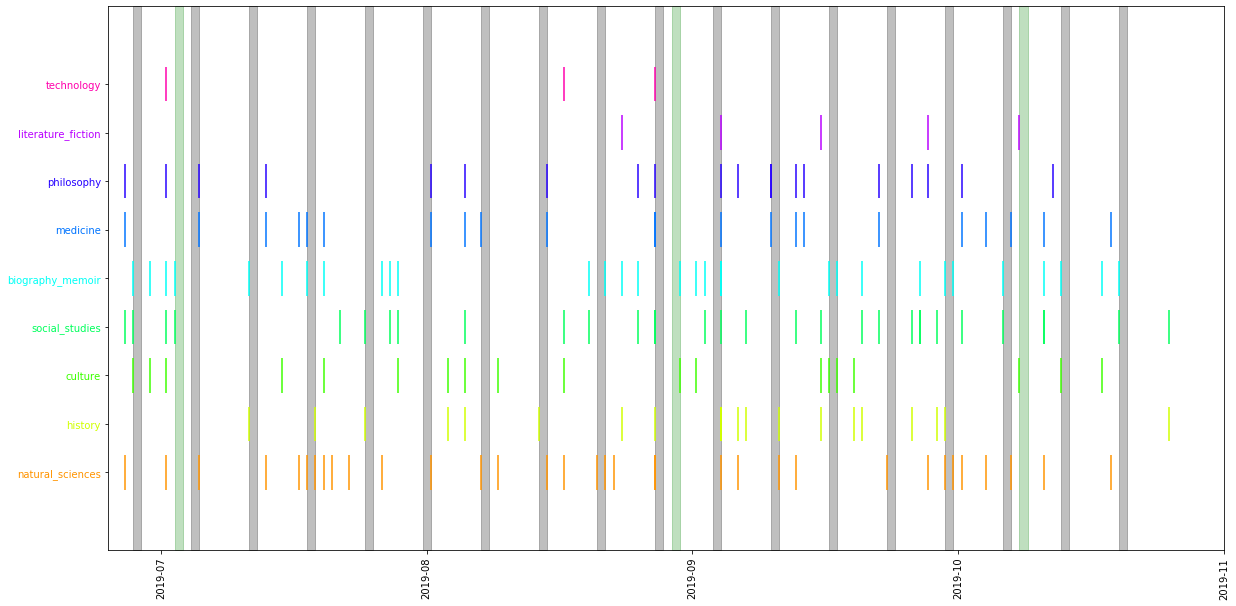

In [31]:
nrows = 1
ncols =1 
fig, ax = plt.subplots(nrows = nrows,ncols = ncols, figsize = (20*ncols,10*nrows))
ax = [ax]
iax = 0

n_months = np.ceil((data['Date Added'].max() - data['Date Added'].min())/np.timedelta64(1, 'M'))
x_ticks = np.linspace(0,1, n_months)

e = labels.set_index((data['Date Added']-time_origin)/time_period)
n_categories = len(e.columns)
offsets = np.linspace(0,1,n_categories)
lengths = 1.0/n_categories - (1.0/n_categories)/5
colors = plt.cm.hsv(np.linspace(0.1,0.9,n_categories))

for r, c in enumerate(e.columns):
    occurance_offsets = e.loc[e[c] == 1].index
    ax[iax].eventplot(list(e.loc[e[c] == 1].index), label = c, 
                      color = colors[r], linelengths = lengths, lineoffsets = offsets[r])
ax[iax].set_ylim([-0.2,1.2])
ax[iax].set_yticks(offsets)
ax[iax].set_yticklabels(e.columns)
for ic in range(len(e.columns)):
    ax[iax].get_yticklabels()[ic].set_color(colors[ic])

x_ticks_labels = [(xt*time_period + time_origin).date().strftime(format = '%Y-%m') for xt in x_ticks]
ax[iax].set_xticks(x_ticks)
ax[iax].set_xticklabels(x_ticks_labels, rotation = 90);


for index, row in weekends.iterrows():
    start = (row['start']-time_origin)/time_period
    end = (row['end']-time_origin)/time_period
    ax[iax].fill_betweenx(y = ax[iax].get_ylim(), 
                    x1 = start, x2 = end,
                   color = 'k', alpha = 0.25)
    
for holiday in holidays:
    start = (holiday-time_origin)/time_period
    end = (holiday + pd.Timedelta('1 days')-time_origin)/time_period
    ax[iax].fill_betweenx(y = ax[iax].get_ylim(), 
                    x1 = start, x2 = end,
                   color = 'g', alpha = 0.25)    

ax[iax].set_xlim([0.8, 1])
plt.show()

# Modeling timeseries

### Set up dummy data with seasonality

In [32]:
from scipy.stats import skewnorm
# Timeseries of fraction of book read per hour
time_idx = pd.date_range(pd.to_datetime('2000-01-01'), pd.to_datetime('2040-01-01'), freq = 'H')

timeseries = pd.DataFrame({'fraction of book read':
                               np.clip(skewnorm.pdf([t.hour for t in time_idx], -10, 20, 5)\
                                        *[2 if t.weekday() in [5,6] else 1 for t in time_idx]\
                                        *[1.1 if t.month in [11, 12, 1, 2] else 1 for t in time_idx]\
                                        *[np.clip(np.log((t.year-2012)*2)*.1, a_min = 0.01, a_max = 2.0) for t in time_idx]
                                        + np.random.normal(0, 0.01, np.shape(time_idx)),
                                       a_min = 0, a_max = 0.5),
                           'timestamp': time_idx}, index = time_idx)

In [33]:
timeseries['fraction of book read'] = timeseries['fraction of book read'].fillna(0)

In [34]:
#timeseries['fraction of book read'].plot()
#timeseries['fraction of book read'].hist(bins = 100)
# Check that weekly count of books read makes sense
#timeseries.groupby(pd.Grouper(key='timestamp', freq='W-MON')).sum().rename(columns = {'fraction of book read':'books read per week'}).hist()

In [35]:
timeseries['month'] = timeseries.index.month
timeseries['weekend'] = [t.weekday() in [5,6] for t in timeseries.index]
timeseries['hour'] = timeseries.index.hour

In [36]:
freq = 'H' # hourly frequency
val_column = 'fraction of book read'

# Setup of filter for smoothing
from scipy.signal import butter
b, a = butter(1, 0.25)

## Local prediction only -- no seasonality consideration

In [52]:
timeseries_subset = timeseries.loc[pd.to_datetime('2029-01-01'):pd.to_datetime('2029-02-01')]

In [53]:
method_parameters = [('ewm', # local trends only, no seasonal component
                      3*24, # using last 3 days of data
                      1, # predict next hour of data
                      {'halflife_divisor': 5, # Weight most recent 5 hours of data in timeseries
                             })]



ewm


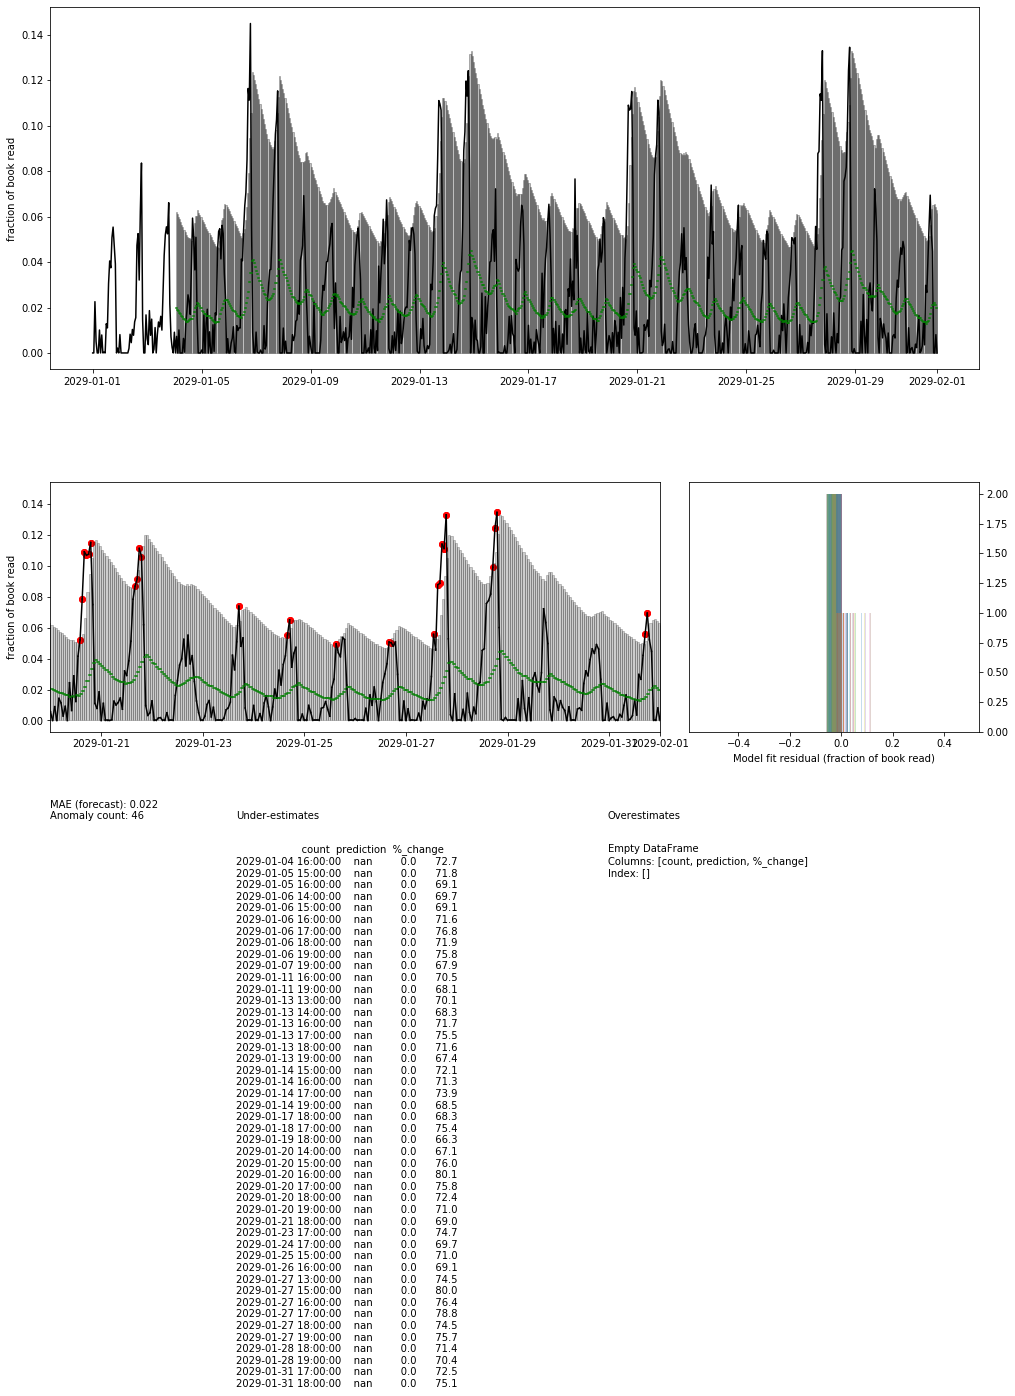

In [57]:
for method, training_window, prediction_window, parameters in method_parameters:
    print(method)
    timeseries_subset['residual'] = np.nan
    timeseries_subset['anomaly'] = np.nan
    timeseries_subset['prediction'] = np.nan
    timeseries_subset['%_change'] = np.nan
    fig, ax1, ax2, ax3, ax4, timeseries_subset = \
            rolling_timeseries_prediction(timeseries_subset, freq, val_column, 
                                          method, parameters, 
                                          training_window, prediction_window,
                                          a=None, b=None, 
                                  print_anomalies = True, verbose = 0,
                                  zoom_time_range = [pd.to_datetime('2029-01-20'), pd.to_datetime('2029-02-01')]);
    

## Seasonal prediction only -- no local adjustments

In [ ]:
method_parameters = [('ewm_grouped', # seasonal trends only, no local component
                     8760*3, # using last three years of data
                     8760 *1, # predict next year of data 
                     {'group_by': ['month', 'weekend', 'hour'], #e.g. comparing all workdays in April at 16:00
                                      'halflife_divisor': 5, # Weight most recent 5 occurance of this group
                                      'smoothing_window_size': 5, 
                                      'smoothing_gaussian_std': 1})]

for method, training_window, prediction_window, parameters in method_parameters:
    print(method)
    timeseries['residual'] = np.nan
    timeseries['anomaly'] = np.nan
    timeseries['prediction'] = np.nan
    timeseries['%_change'] = np.nan
    fig, ax1, ax2, ax3, ax4, timeseries_subset = \
            rolling_timeseries_prediction(timeseries, freq, val_column, 
                                          method, parameters, 
                                          training_window, prediction_window,
                                          a=None, b=None, 
                                  print_anomalies = True, verbose = 0,
                                  zoom_time_range = [pd.to_datetime('2029-01-20'), pd.to_datetime('2029-02-01')]);

# SARIMA method 

### https://pypi.org/project/pmdarima/

In [ ]:
from pmdarima import auto_arima
estimator = auto_arima(seasonal=True, m=168)


In [ ]:
method_parameters = [('sarima', 8760*3, 8760 *1, {'estimator': 
                                                  auto_arima(seasonal = True, 
                                                             m = 8765, #number of observations per seasonal cycle
                                                            )
                                                 }
                     )
                    ]

for method, training_window, prediction_window, parameters in method_parameters:
    print(method)
    timeseries['residual'] = np.nan
    timeseries['anomaly'] = np.nan
    timeseries['prediction'] = np.nan
    timeseries['%_change'] = np.nan
    fig, ax1, ax2, ax3, ax4, timeseries_subset = \
            rolling_timeseries_prediction(timeseries, freq, val_column, 
                                          method, parameters, 
                                          training_window, prediction_window,
                                          a=None, b=None, 
                                  print_anomalies = True, verbose = 0,
                                  zoom_time_range = [pd.to_datetime('2029-01-20'), pd.to_datetime('2029-02-01')]);

# TBATS method 

### https://github.com/intive-DataScience/tbats

In [ ]:
from tbats import TBATS
method_parameters = [('tbats', 8760*3, 8760 *1, {'estimator': TBATS(seasonal_periods=(24.0819024725, # hours per day
                                                         168.573317308, # hours per week,
                                                         8765.8125 # hours per year, including leap years
                                                        ))})
                    ]
for method, training_window, prediction_window, parameters in method_parameters:
    print(method)
    timeseries['residual'] = np.nan
    timeseries['anomaly'] = np.nan
    timeseries['prediction'] = np.nan
    timeseries['%_change'] = np.nan
    fig, ax1, ax2, ax3, ax4, timeseries_subset = \
            rolling_timeseries_prediction(timeseries, freq, val_column, 
                                          method, parameters, 
                                          training_window, prediction_window,
                                          a=None, b=None, 
                                  print_anomalies = True, verbose = 0,
                                  zoom_time_range = [pd.to_datetime('2029-02-20'), pd.to_datetime('2029-03-01')]);